## Imports and data ingestion

`linear_model` for Logistic Regression,

`model_selection` for train-test split and cross-validation,

`metrics` for ROC and AIC

In [1858]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
import sklearn.ensemble as skl_en
import sklearn.model_selection as skl_ms
import sklearn.metrics as skl_met

In [1859]:
rawData = pd.read_csv('train.csv')

## Get Dummies

`Lead` is `0` if the lead is `female`.

In [1860]:
data = rawData.copy()
data['Lead'] = pd.get_dummies(data['Lead'])

## Feature Engineering

We first extract the number of words spoken by the co-lead.

In [1861]:
data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']

It is probably more important to know proportion of words spoken by lead than the absolute number of words.

In [1862]:
data['Proportion of words lead'] = data['Number of words lead']/data['Total words']

We look at the proportion of dialogue from co-lead as well as the ratio of dialogue between co-lead and lead.

In [1863]:
data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']

Similarly for number of words spoken by male or female actors. However, here we normalize by `Total words - Number of words lead` since this only measures non-lead dialogue. We only need `Proportion of words female` since a hypothetical `Proportion of words male` is just `1 - Proportion of words female`.

In [1864]:
data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])

It might be important to look at the ratio of female actors.

In [1865]:
data['Proportion of female actors'] = data['Number of female actors']/(data['Number of male actors'] + data['Number of female actors'])

Perhaps it is important if the lead or co-lead is oldest.

In [1866]:
data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
data['Older lead'] = pd.get_dummies(data['Older lead'])

In [1867]:
data.columns

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead', 'Lead',
       'Number of words co-lead', 'Proportion of words lead',
       'Proportion of words co-lead', 'Ratio words co-lead lead',
       'Proportion of words female', 'Proportion of female actors',
       'Older lead'],
      dtype='object')

Combining all pre-processing into a function

In [1868]:
def pre_process(raw_data):
    data = raw_data.copy()
    
    data['Lead'] = pd.get_dummies(data['Lead'])
    data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']
    data['Proportion of words lead'] = data['Number of words lead']/data['Total words']
    data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
    data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']
    data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])
    data['Proportion of female actors'] = data['Number of female actors']/(data['Number of male actors'] + data['Number of female actors'])
    data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
    data['Older lead'] = pd.get_dummies(data['Older lead'])
    
    return data

# Logistic Regression

In [1869]:
data = pre_process(rawData)

In [1870]:
config = pd.read_csv('config.csv')
trainRatio = config['Train Ratio'][0]
seed = config['Random Seed'][0]
train, test = skl_ms.train_test_split(data, train_size=trainRatio) #, random_state=seed)

In [1871]:
rawFeatures = [
    'Number words female',
    'Total words',
    'Number of words lead',
    'Difference in words lead and co-lead',
    'Number of male actors',
    'Year',
    'Number of female actors',
    'Number words male',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead'
]

featureSet1 = [
    'Year',
    'Gross',
    'Number of female actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Older lead'
]

In [1872]:
features = featureSet1.copy()
#features.remove('Proportion of words female')
target = 'Lead'

## Lasso

Lasso is L1 regularization

We do 20 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 10 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

In [1873]:
logRegLasso = skl_lm.LogisticRegressionCV(Cs=10, cv=20, penalty='l1', solver='liblinear', n_jobs=10)

In [1874]:
logRegLasso.fit(train[features], train[target])

LogisticRegressionCV(cv=20, n_jobs=10, penalty='l1', solver='liblinear')

In [1875]:
logRegLasso.score(test[features], test[target])

0.9115384615384615

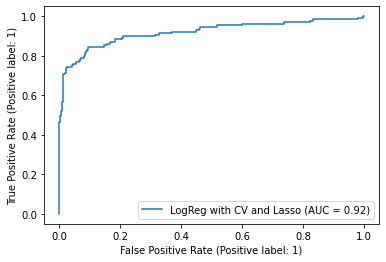

In [1876]:
skl_met.plot_roc_curve(logRegLasso, test[features], test[target], name='LogReg with CV and Lasso')

In [1877]:
skl_met.roc_auc_score(test[target], logRegLasso.predict_proba(test[features])[:,1])

0.9190507345506453

In [1878]:
print(skl_met.classification_report(test[target], logRegLasso.predict(test[features])))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       391
           1       0.88      0.74      0.81       129

    accuracy                           0.91       520
   macro avg       0.90      0.86      0.87       520
weighted avg       0.91      0.91      0.91       520



## Ridge

Ridge is L2-regularization

We do 10 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 100 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

In [1879]:
logRegRidge = skl_lm.LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear', n_jobs=10)
logRegRidge.fit(train[features], train[target])

LogisticRegressionCV(cv=10, n_jobs=10, solver='liblinear')

In [1880]:
logRegRidge.score(test[features], test[target])

0.801923076923077

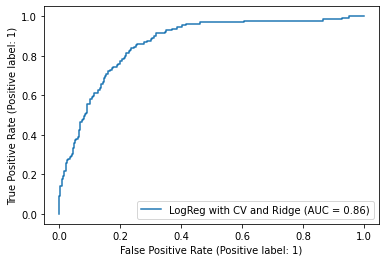

In [1881]:
skl_met.plot_roc_curve(logRegRidge, test[features], test[target], name='LogReg with CV and Ridge')

In [1882]:
skl_met.roc_auc_score(test[target], logRegRidge.predict_proba(test[features])[:,1])

0.8649259501576161

In [1883]:
print(skl_met.classification_report(test[target], logRegRidge.predict(test[features])))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       391
           1       0.70      0.36      0.47       129

    accuracy                           0.80       520
   macro avg       0.76      0.65      0.67       520
weighted avg       0.79      0.80      0.78       520



## Comparison

In [1884]:
logRegLasso.C_

array([2.7825594])

In [1885]:
logRegRidge.C_

array([1291.54966501])

In [1886]:
predLasso = logRegLasso.predict(test[features])
predRidge = logRegRidge.predict(test[features])

In [1887]:
logRegLassoCoefs = dict(zip(features, logRegLasso.coef_[0]))

In [1888]:
for var, coef in logRegLassoCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     -0.00228
Gross                                    -0.00045
Number of female actors                  0.28814
Proportion of female actors              13.30094
Mean Age Male                            0.01138
Mean Age Female                          -0.00719
Age Lead                                 -0.01934
Age Co-Lead                              0.01708
Total words                              -0.00009
Proportion of words lead                 2.34306
Proportion of words co-lead              4.40514
Ratio words co-lead lead                 3.04489
Proportion of words female               -10.97327
Older lead                               -1.24827


In [1889]:
logRegRidgeCoefs = dict(zip(features, logRegRidge.coef_[0]))

In [1890]:
for var, coef in logRegRidgeCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     -0.00062
Gross                                    -0.00067
Number of female actors                  0.39238
Proportion of female actors              0.38648
Mean Age Male                            0.00736
Mean Age Female                          -0.00522
Age Lead                                 -0.03212
Age Co-Lead                              0.02445
Total words                              -0.00009
Proportion of words lead                 0.00157
Proportion of words co-lead              0.29041
Ratio words co-lead lead                 0.86509
Proportion of words female               -0.70500
Older lead                               -0.82625


In [1891]:
sum(predLasso == predRidge)/len(test)

0.8557692307692307

In [1892]:
pd.crosstab(test[target], predLasso)

col_0,0,1
Lead,,
0,378,13
1,33,96


In [1893]:
pd.crosstab(test[target], predRidge)

col_0,0,1
Lead,,
0,371,20
1,83,46
